Детектор аномалии на принципе многократной прогонки реконструкции входного образца до сходимости латентного вектора.
Критерий аномальности - расстояние от первоначального латентного вектора до сошедшего.

In [125]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2

In [126]:
batch_size = 256
learning_rate = 5e-3
num_epochs = 100
latent_dim = 3
mnist_class_anomaly = 4
kernels = 16
fuzzy_rules_count = 27

prefix = f"fuzzy_cvae_mamdani_anomaly"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ssim = piqa.SSIM(window_size = 11, n_channels=1, reduction='none').to(device)

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [127]:
def norm_and_transform(x):
    nimg = x.view(-1, 28, 28)
    nimg = torch.clamp(nimg, 0, 1)
    return nimg

def clamp(x):
    #nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(x, 0, 1)
    return nimg

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(norm_and_transform)
])

augmentation = transforms.Compose([
    transforms.RandomRotation(15, fill=0), 
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), fill=0), 
    #transforms.RandomCrop(size=26),
    #transforms.Resize(size=(28, 28)),
    transforms.Lambda(clamp)
])

In [128]:
def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_class_anomaly)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

54158

загружаем тестовую выборку

In [129]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [130]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

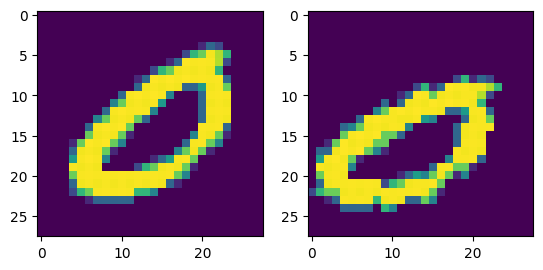

In [131]:
for data,_ in iter(train_loader):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.imshow(data[0].squeeze())
    plt.subplot(R, C, 2)
    plt.imshow(augmentation(data)[0].squeeze())
    
    
    break

## Модель

In [132]:
class TermAverageActivationStatsLayer(torch.nn.Module):
    def __init__(self, terms_count, alpha=1e-2):
        """
        """
        super().__init__()
        #self.dummy = torch.nn.Parameter(torch.empty(0))
        self.terms_count = terms_count
        self.alpha = alpha
        self.accumulated_average_activation = None
        

    def forward(self, x):
        """
        """
        ava = x.mean(0)
        if self.accumulated_average_activation is None:
            self.accumulated_average_activation = ava
        else:
            self.accumulated_average_activation = (1 - self.alpha) * self.accumulated_average_activation + self.alpha * ava

        return x

    def get_norm_stats(self, eps=1e-7):
        """
        
        """
        s = self.accumulated_average_activation.sum() + eps
        return (self.accumulated_average_activation / s).detach()

In [133]:
class TermLatentSpaceCentroidTrackingLayer(torch.nn.Module):
    def __init__(self, latent_dim, alpha=1e-3):
        """
        """
        super().__init__()
        #self.dummy = torch.nn.Parameter(torch.empty(0))
        self.latent_dim = latent_dim
        self.alpha = alpha
        self.aver_centroid = None

    def forward(self, latent_vectors):
        """
        """
        avc = latent_vectors.mean(0)
        if self.aver_centroid is None:
            self.aver_centroid = avc
        else:
            self.aver_centroid = (1 - self.alpha) * self.aver_centroid + self.alpha * avc
        return latent_vectors

    def get_average_centroid(self):
        """
        
        """
        return self.aver_centroid.detach()

In [134]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.SiLU()]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, kernels):
        super(Encoder, self).__init__()
                
        self.conv1 = conv_block(1, 2*kernels)
        self.conv2 = conv_block(2*kernels, 4*kernels, pool=True)
        self.res1 = nn.Sequential(conv_block(4*kernels, 4*kernels), conv_block(4*kernels, 4*kernels))
        
        self.conv3 = conv_block(4*kernels, 8*kernels, pool=True)
        self.conv4 = conv_block(8*kernels, 16*kernels, pool=True)
        self.res2 = nn.Sequential(conv_block(16*kernels, 16*kernels), conv_block(16*kernels, 16*kernels))

        #self.after_sum = nn.SiLU()
        #self.softplus = nn.Softplus()
        self.latent = nn.Sequential(
            nn.Conv2d(16*kernels, latent_dim, 3),
            #nn.BatchNorm2d(latent_dim, track_running_stats=True),
            nn.Sigmoid(),
            nn.Flatten(),
            #nn.Linear(16*kernels*9, latent_dim), # mean + variance.
        )

         
    def forward(self, x):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        out = self.latent(out)

        return out

In [135]:
inp = torch.rand(10, 1, 28, 28)
m = Encoder(latent_dim, 2)
mu = m.forward(inp)
mu[0].shape

torch.Size([3])

In [136]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, fuzzy_rules_count, kernels):
        super(Decoder, self).__init__()

        rscale = 5
        initial_centroids = rscale * np.zeros((fuzzy_rules_count, latent_dim))
        initial_scales = rscale * np.ones((fuzzy_rules_count, latent_dim))

        linex = 0
        linez = 0
        i = 0
        for x in np.linspace(0.0, 1.0, num = 3):
            for y in np.linspace(0.0, 1.0, num = fuzzy_rules_count // 3):
                initial_centroids[i][0] = rscale*(x)
                initial_centroids[i][1] = rscale*(y)
                i = i + 1

        self.fuzzy = nn.Sequential(
            TermLatentSpaceCentroidTrackingLayer(latent_dim),
            FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=False),
            TermAverageActivationStatsLayer(fuzzy_rules_count)
            #DefuzzyLinearLayer.from_dimensions(fuzzy_rules_count, 28*28, with_norm=False)
        )
        

        self.input = nn.Sequential(
            nn.Unflatten(1, (fuzzy_rules_count, 1, 1)),
            nn.BatchNorm2d(fuzzy_rules_count, track_running_stats=True),
            nn.SiLU(),
        )

        self.block_1 = nn.Sequential(
            nn.ConvTranspose2d(fuzzy_rules_count, 16*kernels, 4),
            nn.BatchNorm2d(16*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(16*kernels, 16*kernels, 4),
            nn.BatchNorm2d(16*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_2 = nn.Sequential(
            nn.ConvTranspose2d(16*kernels, 8*kernels, 4),
            nn.BatchNorm2d(8*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(8*kernels, 8*kernels, 4),
            nn.BatchNorm2d(8*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_3 = nn.Sequential(
            nn.ConvTranspose2d(8*kernels, 4*kernels, 4),
            nn.BatchNorm2d(4*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(4*kernels, 4*kernels, 4),
            nn.BatchNorm2d(4*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_4 = nn.Sequential(
            nn.ConvTranspose2d(4*kernels, 2*kernels, 4),
            nn.BatchNorm2d(2*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(2*kernels, 2*kernels, 4),
            nn.BatchNorm2d(2*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_5 = nn.Sequential(
            nn.ConvTranspose2d(2*kernels, kernels, 2),
            nn.BatchNorm2d(kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(kernels, kernels, 2),
            nn.BatchNorm2d(kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.output = nn.Sequential(
            nn.ConvTranspose2d(kernels, 1, 2),
            nn.Sigmoid() 
        )
        self.upscale_1 = nn.Sequential(nn.ConvTranspose2d(fuzzy_rules_count, 16*kernels, kernel_size=7))
        self.upscale_2 = nn.Sequential(nn.ConvTranspose2d(16*kernels, 8*kernels, kernel_size=7))
        self.upscale_3 = nn.Sequential(nn.ConvTranspose2d( 8*kernels, 4*kernels, kernel_size=7))
        self.upscale_4 = nn.Sequential(nn.ConvTranspose2d( 4*kernels, 2*kernels, kernel_size=7))
        self.upscale_5 = nn.Sequential(nn.ConvTranspose2d( 2*kernels, kernels,   kernel_size=3))
        self.after_sum = nn.SiLU()
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """
        fz = self.fuzzy(z)

        #fzs = fz.sum(-1).reshape(-1, 1)
        #fz = fz / fzs
        
        mapx = self.input(fz)

        x = self.decode_from_mp(mapx)
        return x, fz, mapx
    
    def decode_from_fz(self, fz):
        mapx = self.input(fz)
        x = self.decode_from_mp(mapx)
        return x

    def decode_from_mp(self, x):
        res = self.upscale_1(x)
        #print(res.shape)
        x = self.block_1(x)
        #print(x.shape)
        x = self.after_sum(x+res)

        res = self.upscale_2(x)
        #print(res.shape)
        x = self.block_2(x)
        #print(x.shape)
        x = self.after_sum(x+res)

        res = self.upscale_3(x)
        x = self.block_3(x)
        x = self.after_sum(x+res)

        res = self.upscale_4(x)
        x = self.block_4(x)
        x = self.after_sum(x+res)

        res = self.upscale_5(x)
        x = self.block_5(x)
        x = self.after_sum(x+res)
        
        return self.output(x)
    
inp = torch.rand(10, latent_dim)
m = Decoder(latent_dim, fuzzy_rules_count, 2)
mu = m.forward(inp)
mu[0].shape

torch.Size([10, 1, 28, 28])

In [137]:
class VAE(nn.Module):
    """
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim, fuzzy_rules_count, kernels):
        super(VAE, self).__init__()

        self.encoder = Encoder(latent_dim, kernels)        
        self.decoder = Decoder(latent_dim, fuzzy_rules_count, kernels)
        #self.resd = Decoder(latent_dim, fuzzy_rules_count)
        

    def forward(self, x):
        """
        
        """
        mu = self.encoder(x)
        x_recon, fz, _ = self.decoder(mu)
        
        return mu, x_recon, fz
    
    def half_pass(self, x):
        """
        
        """
        mu = self.encoder(x)
        return mu
    
    def decoder_pass(self, x):
        r, f, _ = self.decoder(x)
        return r, f

## Обучение

In [138]:
model = VAE(latent_dim=latent_dim, fuzzy_rules_count=fuzzy_rules_count, kernels=kernels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 6,299,803


VAE(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (res1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2):

In [139]:
#optimizer = torch.optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()), lr=learning_rate)
#optimizer_d = torch.optim.Adam(model.delta_decoder.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))

In [140]:
def tarctanh(x):
    return 0.5 * torch.log((1+x)/(1-x))

def log_norm_const(x, eps = 1e-6):
    # numerically stable computation
    x = torch.clamp(x, eps, 1 - eps)
    x = torch.where((x < 0.49) | (x > 0.51), x, 0.49 *
            torch.ones_like(x))
    return torch.log((2 * tarctanh(1 - 2 * x)) /
                    (1 - 2 * x) + eps)

def xent_continuous_ber(recon_x, x, pixelwise=False):
    ''' p(x_i|z_i) a continuous bernoulli '''
    eps = 1e-6
    if pixelwise:
        return (x * torch.log(recon_x + eps) +
                        (1 - x) * torch.log(1 - recon_x + eps) +
                        log_norm_const(recon_x, eps))
    else:
        return torch.mean(torch.sum(x * torch.log(recon_x + eps) +
                        (1 - x) * torch.log(1 - recon_x + eps) +
                        log_norm_const(recon_x, eps), dim=(1, )), dim=(1, 2))
    

a = -torch.ones(3, 1, 28, 28)
b = -torch.ones(3, 1, 28, 28)

xent_continuous_ber((a + 1)/2, (b + 1)/2)

tensor([2.6248, 2.6248, 2.6248])

In [141]:
def compute_vae_loss(x, recon_x):
    
    #loss_recon = (x - recon_x).square().sum(-1).sum(-1).mean()
    loss_recon = -xent_continuous_ber(recon_x, x)
    loss_recon = loss_recon.mean()
    #loss_recon = (1 - ssim(recon_x.clamp(0, 1), x))
    #loss_recon = loss_recon.mean()
    
    #raw_loss_recon = (1 - diff).square() #F.binary_cross_entropy((recon_x+1)/2, (x + 1)/2, reduction='none').sum(-1).mean()#
    #loss_recon = raw_loss_recon.mean()
    
    return loss_recon #(x-recon_x).square().sum(-1).sum(-1).mean()
    

In [142]:
def compute_fuzzy_loss(fz):
    

    return (1 - fz.sum(-1)).square().mean() #(0.999 - (tops[:,0]+tops[:,1]).clamp(max=0.999)).mean() + tops[:, 2].clamp(min=0.001).mean()

In [143]:
def compute_centroids_loss(fuzzy_layer):
    
    c = fuzzy_layer[1].get_centroids()
    c = c.mean(0)
    ac = fuzzy_layer[0].get_average_centroid()

    return (c-ac).square().mean()


In [144]:
eigens = model.decoder.fuzzy[1].get_transformation_matrix_eigenvals().real


In [145]:
def compute_fshape_loss(fuzzy_layer):
    
    eigens = fuzzy_layer.get_transformation_matrix_eigenvals().real
    fz_volume = (0.1 - eigens).square()
    fz_volume = fz_volume.mean()
    
    #fz_scales = (1 - eigens).square().mean()

    return fz_volume
    

In [146]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [147]:
def get_arate(inp):
    _, x_recon, _ = model.forward(inp)
    
    # prev_mu = mu
    # sum = torch.zeros_like(mu)
    
    # for i in range(20):
    #     recon_x = model.decoder_pass(mu)
    #     mu, _, _ = model.half_pass(recon_x)
    #     sum += (mu - prev_mu).abs()
    #     prev_mu = mu
    # +
    return (1 - ssim(x_recon.clamp(0, 1), inp)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

In [148]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def train(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.train()  
    
    model.decoder.fuzzy[1].set_requires_grad_rot(False)
    model.decoder.fuzzy[1].set_requires_grad_scales(False)
    model.decoder.fuzzy[1].set_requires_grad_centroids(False)
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        adata = augmentation(data)
        
        optimizer.zero_grad()  
        z = model.half_pass(adata)  
        x_reconstruct, fz = model.decoder_pass(z)
        #x_resd, _ = model.resd_pass(z)
        loss_reconstruct = compute_vae_loss(data, x_reconstruct)
        #loss_resd = compute_vae_loss((data - x_reconstruct).abs(), x_resd)
        #fz_loss = compute_fuzzy_loss(fz)
        #fz_volume = compute_fshape_loss(model.decoder.fuzzy[1])
        
        ev_loss = keep_eigenvals_positive_loss(model.decoder.fuzzy[1])
        if ev_loss.item() > 0:
            ev_loss.backward(retain_graph=True)
        
        #.backward(retain_graph=True)
        #fz_volume.backward(retain_graph=True)
        loss_reconstruct.backward()
        #loss_resd.backward() 
        
        optimizer.step()  
        
        if sched is not None:
            sched.step()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.12)    
        
    if writer is not None:
        writer.add_scalar('ADFVAE/LR', get_lr(optimizer), global_step=epoch)
        
    return prev_updates + len(dataloader)

In [149]:
def shannon_entropy(fuzzy):
    distr = fuzzy[2].get_norm_stats()
    dim = distr.shape[0]
    return np.log(dim) + (distr*distr.log()).sum()

In [150]:
fixed_random_z = torch.randn(16, latent_dim).to(device)

def test(model, dataloader, cur_step, epoch, writer=None):
    model.eval() 
    test_recon_loss = 0
    test_kl_loss = 0
    test_fz_loss = 0
    test_fzvol_loss = 0
    test_c_loss = 0
    
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = get_arate(data)
            
            for f, l in  zip(rates, lab):
                lab_pred.append(f)        
                if l == mnist_class_anomaly:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
    fpr, tpr, _ = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    embedings = []
    labels_expected = []
    centroids = model.decoder.fuzzy[1].get_centroids().detach().cpu().numpy()
    #centroids_resd = model.resd.fuzzy[1].get_centroids().detach().cpu().numpy()
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing', disable=True):
            data = data.to(device)
            z = model.half_pass(data)  
            x_reconstruct, fz = model.decoder_pass(z)
            #x_resd, _ = model.resd_pass(z)
            
            embedings.append(z.cpu().numpy())
            labels_expected.append(target.cpu().numpy())

            loss_recon = compute_vae_loss(data, x_reconstruct)
            #loss_resd = compute_vae_loss((data - x_reconstruct).abs(), x_resd)
            fz_volume = compute_fshape_loss(model.decoder.fuzzy[1])
            c_loss = compute_centroids_loss(model.decoder.fuzzy)    
            fz_loss = compute_fuzzy_loss(fz)

            test_recon_loss += loss_recon.item()
            #test_kl_loss += loss_resd.item()
            test_fz_loss += fz_loss.item()
            test_fzvol_loss += fz_volume.item()
            test_c_loss += c_loss.item()

    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    if epoch % 5 == 1:
        plt.figure(figsize=(18, 6))

        R, C = 1, 3

        plt.subplot(R, C, 1)
        plt.title("MNIST XY")
        plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
        plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)
        #plt.scatter(centroids_resd[:, 0],      centroids_resd[:, 1], marker='2', c='red', s= 20)
        
        # plt.xlim((-1, 1))
        # plt.ylim((-1, 1))

        plt.subplot(R, C, 2)
        plt.title("MNIST XZ")
        plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)
        plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)
        #plt.scatter(centroids_resd[:, 0], centroids_resd[:, 2], marker='2', c='red', s= 20)
        
        # plt.xlim((-1, 1))
        # plt.ylim((-1, 1))

        plt.show()
    
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fz_loss /= len(dataloader)
    test_fzvol_loss /= len(dataloader)
    test_c_loss /= len(dataloader)
    print(f'[{cur_step}] Reconstruction loss: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} AUC {roc_auc:.4f} FZ {test_fz_loss:.4f} FZVOL {test_fzvol_loss:.4f} CENTROIDS DISCREPANCY {test_c_loss:.4f} SHANNON {shannon_entropy(model.decoder.fuzzy)}')
    #print(f'Average activation stats: {model.decoder.fuzzy[2].get_norm_stats()}')
    #print(f'Average centroid stats: {model.decoder.fuzzy[0].get_average_centroid()}')
    if writer is not None:
        writer.add_histogram('ADFVAE/TermActivation', model.decoder.fuzzy[2].get_norm_stats(), cur_step)
        writer.add_scalar('ADFVAE/AUC', roc_auc, global_step=cur_step)
        writer.add_scalar('ADFVAE/Reconstruction', test_recon_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/KLD', test_kl_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/Fuzzy', test_fz_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/Fuzzy/Vol', test_fzvol_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/Fuzzy/CDist', test_c_loss, global_step=cur_step)
        
        samples, _ = model.decoder_pass(fixed_random_z)
        #samples_resd, _ = model.resd_pass(fixed_random_z)
        writer.add_images('ADFVAE/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)
        #writer.add_images('ADFVAE/ResdSamples', samples_resd.view(-1, 1, 28, 28), global_step=cur_step)

In [151]:
prev_updates = 0

[212] Reconstruction loss: -1.7806, KLD: 0.0000 AUC 0.6831 FZ 3.9369 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0678 SHANNON 0.16088104248046875


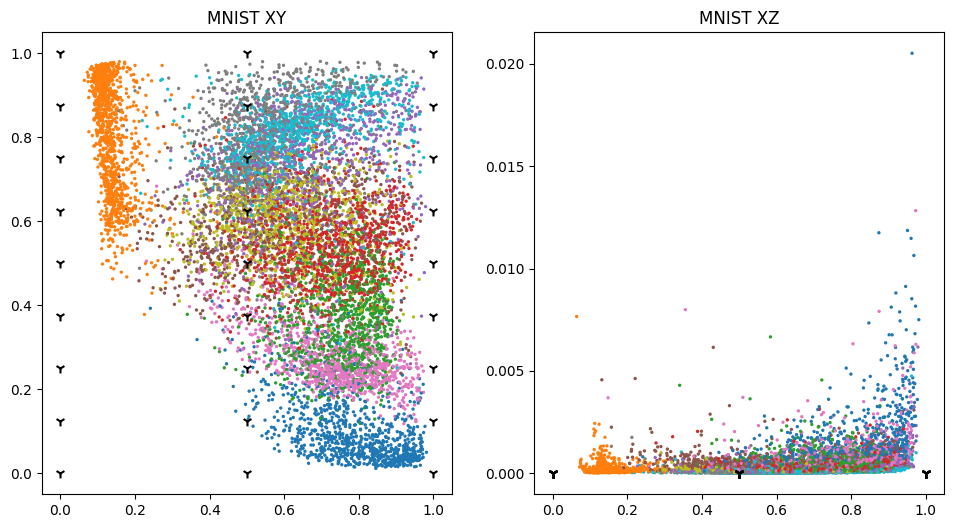

[424] Reconstruction loss: -1.7808, KLD: 0.0000 AUC 0.7595 FZ 4.6331 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0393 SHANNON 0.1728382110595703
[636] Reconstruction loss: -1.7863, KLD: 0.0000 AUC 0.6890 FZ 4.2433 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0241 SHANNON 0.18144512176513672
[848] Reconstruction loss: -1.8070, KLD: 0.0000 AUC 0.6543 FZ 3.6141 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0164 SHANNON 0.1807107925415039
[1060] Reconstruction loss: -1.8842, KLD: 0.0000 AUC 0.7536 FZ 3.8094 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0128 SHANNON 0.17148232460021973
[1272] Reconstruction loss: -1.8408, KLD: 0.0000 AUC 0.8150 FZ 4.2339 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0110 SHANNON 0.1622781753540039


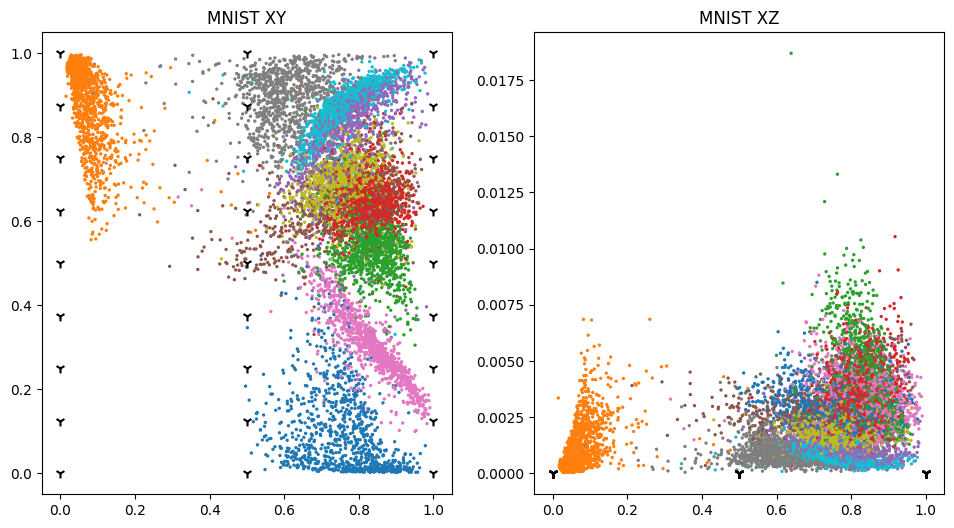

[1484] Reconstruction loss: -1.8601, KLD: 0.0000 AUC 0.6603 FZ 3.6597 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0109 SHANNON 0.176177978515625
[1696] Reconstruction loss: -1.8417, KLD: 0.0000 AUC 0.6935 FZ 3.5589 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0114 SHANNON 0.17305803298950195
[1908] Reconstruction loss: -1.8704, KLD: 0.0000 AUC 0.6854 FZ 3.5885 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0120 SHANNON 0.17755770683288574
[2120] Reconstruction loss: -1.9115, KLD: 0.0000 AUC 0.7749 FZ 3.7461 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0129 SHANNON 0.19152069091796875
[2332] Reconstruction loss: -1.8899, KLD: 0.0000 AUC 0.7264 FZ 3.7339 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0137 SHANNON 0.18494367599487305


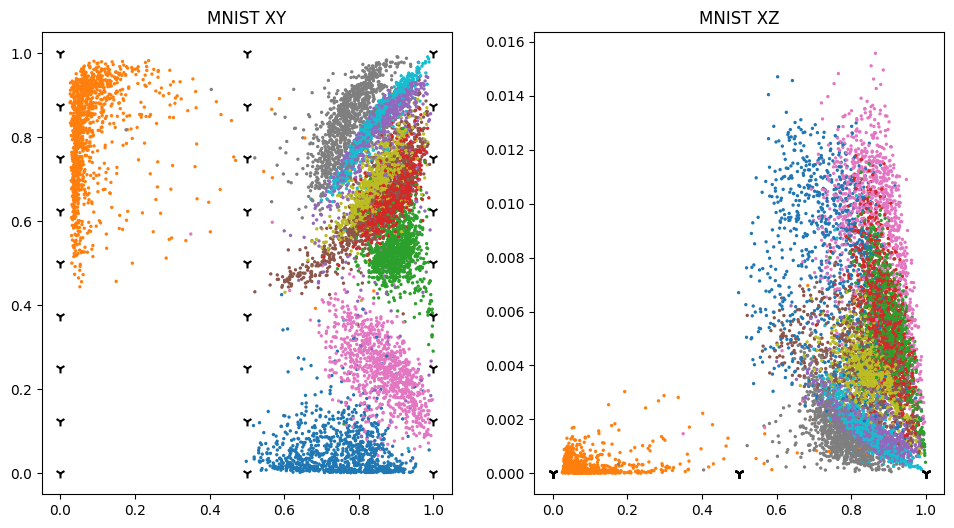

[2544] Reconstruction loss: -1.8070, KLD: 0.0000 AUC 0.8419 FZ 3.8048 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0147 SHANNON 0.20174789428710938
[2756] Reconstruction loss: -1.9125, KLD: 0.0000 AUC 0.7303 FZ 3.5469 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0156 SHANNON 0.19697165489196777
[2968] Reconstruction loss: -1.8784, KLD: 0.0000 AUC 0.7394 FZ 4.0582 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0158 SHANNON 0.1786670684814453
[3180] Reconstruction loss: -1.8999, KLD: 0.0000 AUC 0.7310 FZ 3.7102 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0161 SHANNON 0.18372035026550293
[3392] Reconstruction loss: -1.9207, KLD: 0.0000 AUC 0.7371 FZ 3.7450 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0163 SHANNON 0.1746044158935547


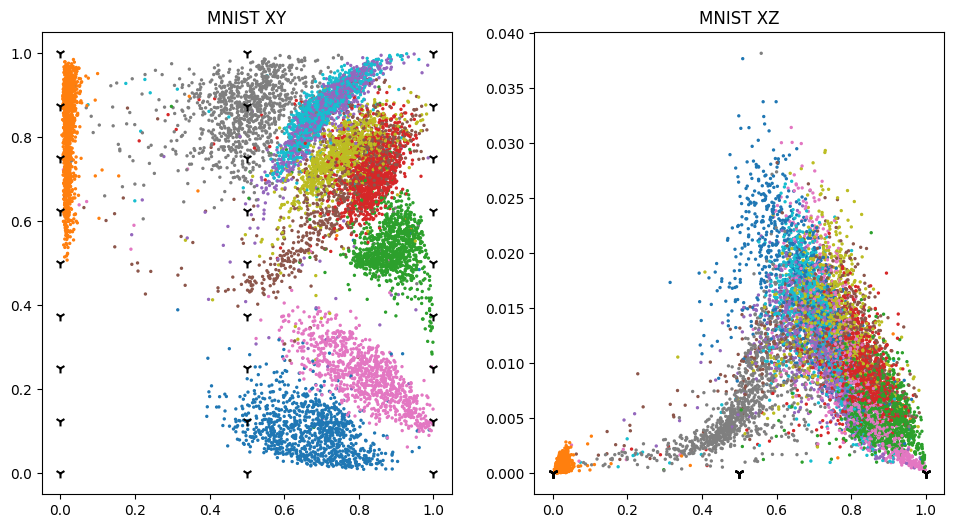

[3604] Reconstruction loss: -1.8428, KLD: 0.0000 AUC 0.7466 FZ 3.8762 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0162 SHANNON 0.15859556198120117
[3816] Reconstruction loss: -1.8812, KLD: 0.0000 AUC 0.7058 FZ 3.4626 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0166 SHANNON 0.20026397705078125
[4028] Reconstruction loss: -1.9004, KLD: 0.0000 AUC 0.7083 FZ 3.6240 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0169 SHANNON 0.19831061363220215
[4240] Reconstruction loss: -1.9159, KLD: 0.0000 AUC 0.7480 FZ 3.6449 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0171 SHANNON 0.19173312187194824
[4452] Reconstruction loss: -1.8483, KLD: 0.0000 AUC 0.6531 FZ 3.7286 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0178 SHANNON 0.20524835586547852


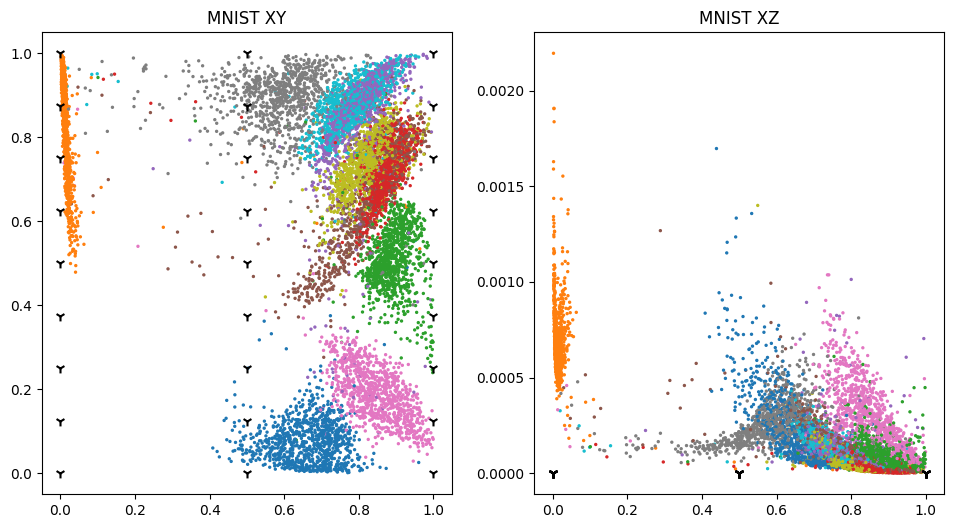

[4664] Reconstruction loss: -1.9016, KLD: 0.0000 AUC 0.8442 FZ 3.6172 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0178 SHANNON 0.16918277740478516
[4876] Reconstruction loss: -1.8232, KLD: 0.0000 AUC 0.7585 FZ 3.4105 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0180 SHANNON 0.19191765785217285
[5088] Reconstruction loss: -1.9417, KLD: 0.0000 AUC 0.7123 FZ 3.6298 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0181 SHANNON 0.18451261520385742
[5300] Reconstruction loss: -1.8857, KLD: 0.0000 AUC 0.7442 FZ 3.9435 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0179 SHANNON 0.1691584587097168
[5512] Reconstruction loss: -1.8953, KLD: 0.0000 AUC 0.6976 FZ 3.3674 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0182 SHANNON 0.19286775588989258


[5724] Reconstruction loss: -1.8648, KLD: 0.0000 AUC 0.8379 FZ 3.9485 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0181 SHANNON 0.17268943786621094
[5936] Reconstruction loss: -1.9088, KLD: 0.0000 AUC 0.6577 FZ 3.5779 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0185 SHANNON 0.20072031021118164
[6148] Reconstruction loss: -1.8833, KLD: 0.0000 AUC 0.6693 FZ 3.7634 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0183 SHANNON 0.16824555397033691
[6360] Reconstruction loss: -1.9371, KLD: 0.0000 AUC 0.6837 FZ 3.6359 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0182 SHANNON 0.17626476287841797
[6572] Reconstruction loss: -1.9334, KLD: 0.0000 AUC 0.7027 FZ 3.5556 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0180 SHANNON 0.1772770881652832


[6784] Reconstruction loss: -1.9394, KLD: 0.0000 AUC 0.6850 FZ 3.5957 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0179 SHANNON 0.1805591583251953
[6996] Reconstruction loss: -1.9277, KLD: 0.0000 AUC 0.7750 FZ 3.5295 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0180 SHANNON 0.18118953704833984
[7208] Reconstruction loss: -1.9333, KLD: 0.0000 AUC 0.6824 FZ 3.5332 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0181 SHANNON 0.1837000846862793
[7420] Reconstruction loss: -1.8958, KLD: 0.0000 AUC 0.8366 FZ 3.4391 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0182 SHANNON 0.17928791046142578
[7632] Reconstruction loss: -1.9565, KLD: 0.0000 AUC 0.7519 FZ 3.7171 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0183 SHANNON 0.1811227798461914


[7844] Reconstruction loss: -1.9027, KLD: 0.0000 AUC 0.7188 FZ 3.7505 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0184 SHANNON 0.18651390075683594
[8056] Reconstruction loss: -1.9005, KLD: 0.0000 AUC 0.7358 FZ 3.8263 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0182 SHANNON 0.18096017837524414
[8268] Reconstruction loss: -1.8771, KLD: 0.0000 AUC 0.6659 FZ 3.7066 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0184 SHANNON 0.2007765769958496
[8480] Reconstruction loss: -1.9508, KLD: 0.0000 AUC 0.7699 FZ 3.7777 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0186 SHANNON 0.19047212600708008
[8692] Reconstruction loss: -1.8484, KLD: 0.0000 AUC 0.6953 FZ 3.9539 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0182 SHANNON 0.16935968399047852


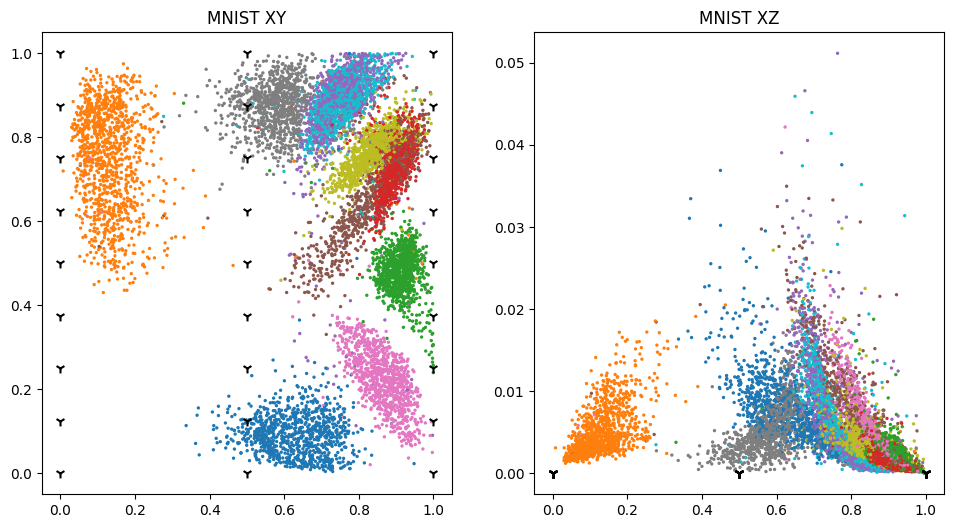

[8904] Reconstruction loss: -1.9629, KLD: 0.0000 AUC 0.7275 FZ 3.7313 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0180 SHANNON 0.17656636238098145
[9116] Reconstruction loss: -1.9209, KLD: 0.0000 AUC 0.7914 FZ 3.5665 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0183 SHANNON 0.19649839401245117
[9328] Reconstruction loss: -1.9457, KLD: 0.0000 AUC 0.7061 FZ 3.6885 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0184 SHANNON 0.18673110008239746
[9540] Reconstruction loss: -1.9021, KLD: 0.0000 AUC 0.6681 FZ 3.6824 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0183 SHANNON 0.1735844612121582
[9752] Reconstruction loss: -1.9826, KLD: 0.0000 AUC 0.7679 FZ 2.8822 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0179 SHANNON 0.15307331085205078


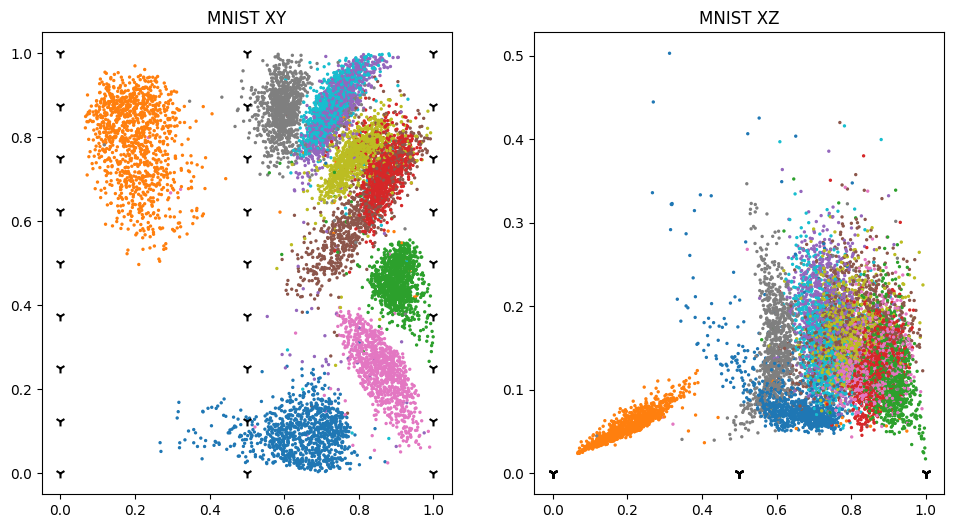

[9964] Reconstruction loss: -1.9735, KLD: 0.0000 AUC 0.7957 FZ 2.1341 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0181 SHANNON 0.16080093383789062
[10176] Reconstruction loss: -1.9667, KLD: 0.0000 AUC 0.8296 FZ 2.2449 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0183 SHANNON 0.1458137035369873
[10388] Reconstruction loss: -1.9788, KLD: 0.0000 AUC 0.7891 FZ 2.0571 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0187 SHANNON 0.14183712005615234
[10600] Reconstruction loss: -1.9729, KLD: 0.0000 AUC 0.8025 FZ 1.8899 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0191 SHANNON 0.14004755020141602
[10812] Reconstruction loss: -1.9877, KLD: 0.0000 AUC 0.7462 FZ 1.5863 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0198 SHANNON 0.135115385055542


[11024] Reconstruction loss: -2.0067, KLD: 0.0000 AUC 0.8173 FZ 1.4794 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0207 SHANNON 0.14251327514648438
[11236] Reconstruction loss: -1.9636, KLD: 0.0000 AUC 0.7928 FZ 1.7733 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0217 SHANNON 0.1485447883605957
[11448] Reconstruction loss: -2.0253, KLD: 0.0000 AUC 0.8394 FZ 1.2598 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0229 SHANNON 0.1463639736175537
[11660] Reconstruction loss: -2.0014, KLD: 0.0000 AUC 0.8421 FZ 1.2153 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0238 SHANNON 0.14292144775390625
[11872] Reconstruction loss: -2.0203, KLD: 0.0000 AUC 0.8168 FZ 1.2265 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0246 SHANNON 0.13985490798950195


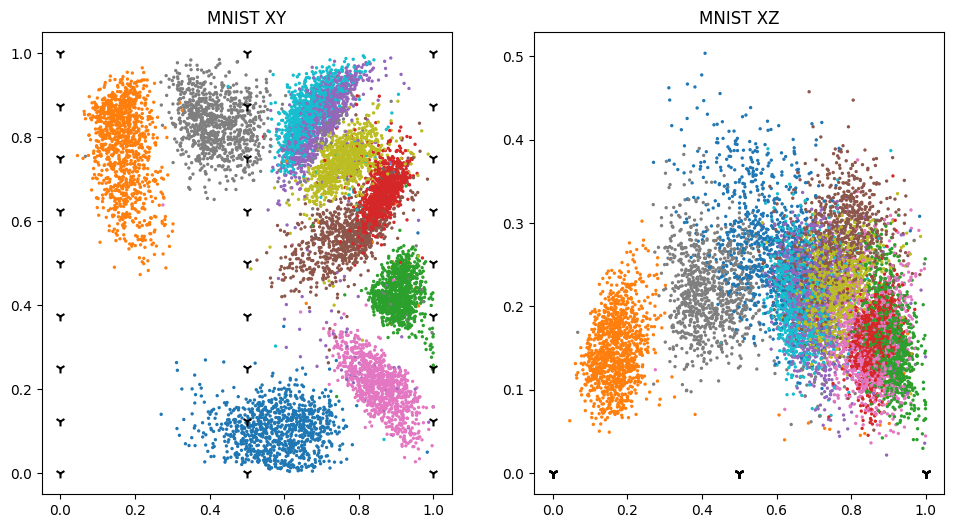

[12084] Reconstruction loss: -1.9733, KLD: 0.0000 AUC 0.8080 FZ 1.4179 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0250 SHANNON 0.14149880409240723
[12296] Reconstruction loss: -2.0022, KLD: 0.0000 AUC 0.8723 FZ 1.3291 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0255 SHANNON 0.13902688026428223
[12508] Reconstruction loss: -1.9878, KLD: 0.0000 AUC 0.7966 FZ 1.3890 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0259 SHANNON 0.1364119052886963
[12720] Reconstruction loss: -2.0172, KLD: 0.0000 AUC 0.8286 FZ 1.2305 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0264 SHANNON 0.14038777351379395
[12932] Reconstruction loss: -2.0249, KLD: 0.0000 AUC 0.8380 FZ 1.0276 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0270 SHANNON 0.13365554809570312


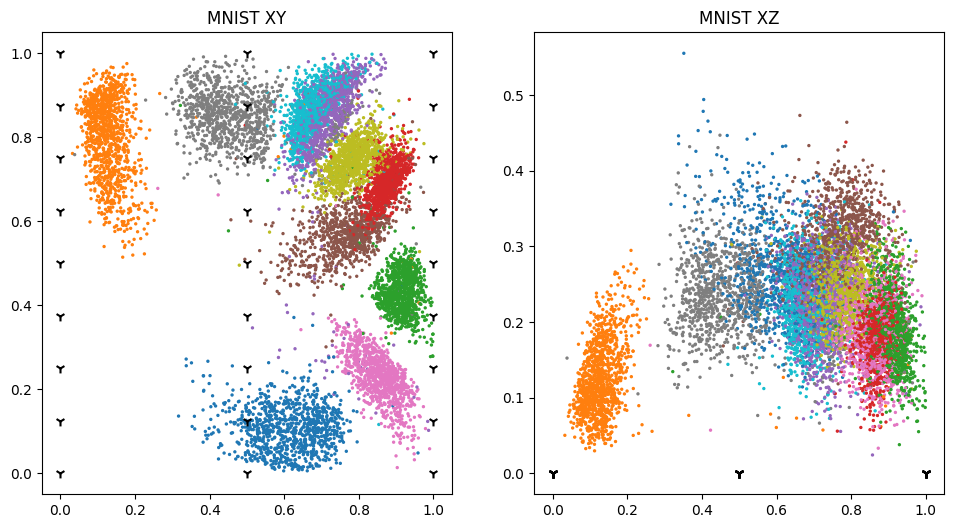

[13144] Reconstruction loss: -2.0322, KLD: 0.0000 AUC 0.8485 FZ 1.1971 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0274 SHANNON 0.13395929336547852
[13356] Reconstruction loss: -1.9420, KLD: 0.0000 AUC 0.8450 FZ 1.3042 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0275 SHANNON 0.13451814651489258
[13568] Reconstruction loss: -1.9927, KLD: 0.0000 AUC 0.7616 FZ 1.0535 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0279 SHANNON 0.14209651947021484
[13780] Reconstruction loss: -2.0030, KLD: 0.0000 AUC 0.7958 FZ 1.0250 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0284 SHANNON 0.1380324363708496
[13992] Reconstruction loss: -2.0183, KLD: 0.0000 AUC 0.8411 FZ 0.9064 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0289 SHANNON 0.1390237808227539


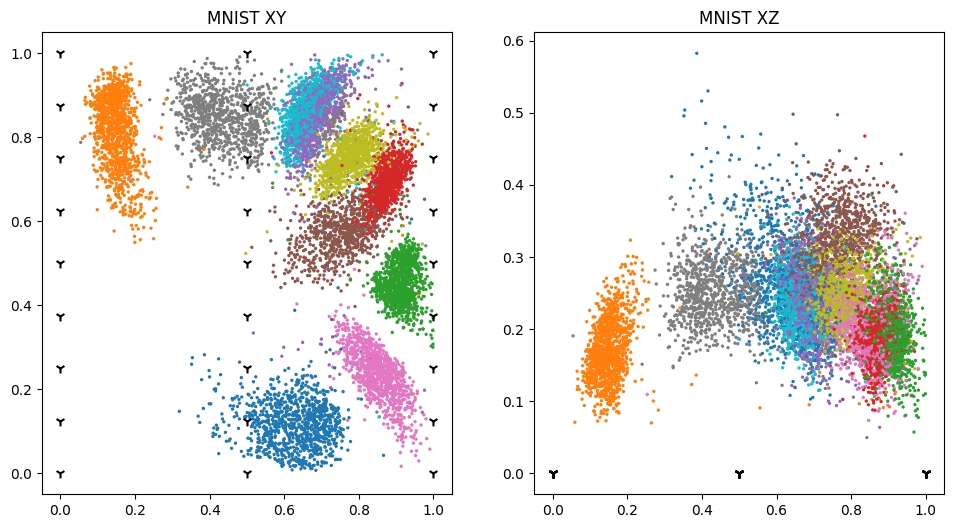

[14204] Reconstruction loss: -2.0484, KLD: 0.0000 AUC 0.8296 FZ 1.0039 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0292 SHANNON 0.13936519622802734
[14416] Reconstruction loss: -1.9621, KLD: 0.0000 AUC 0.8439 FZ 0.8293 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0296 SHANNON 0.13798308372497559
[14628] Reconstruction loss: -2.0449, KLD: 0.0000 AUC 0.8202 FZ 0.9599 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0300 SHANNON 0.14071345329284668
[14840] Reconstruction loss: -2.0429, KLD: 0.0000 AUC 0.8327 FZ 0.8631 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0304 SHANNON 0.13792753219604492
[15052] Reconstruction loss: -1.9869, KLD: 0.0000 AUC 0.7847 FZ 0.8991 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0308 SHANNON 0.14346694946289062


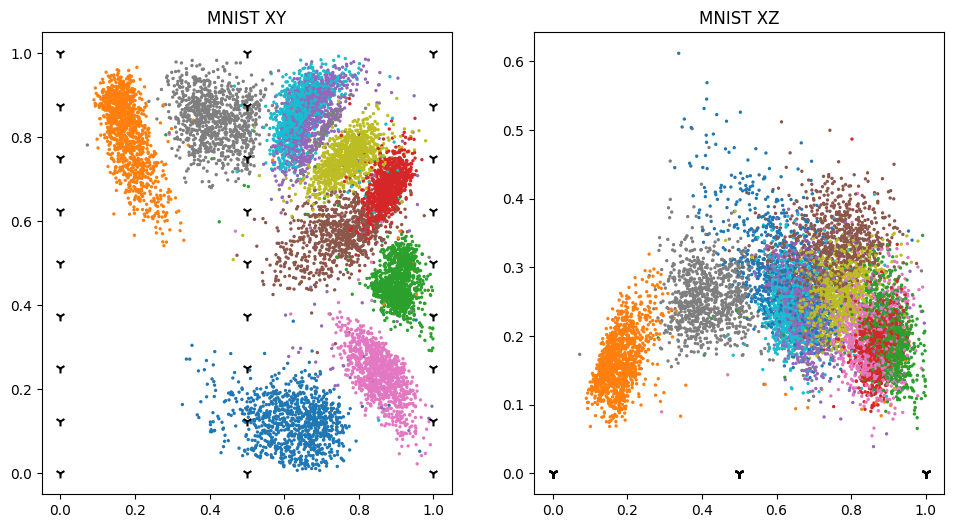

[15264] Reconstruction loss: -2.0437, KLD: 0.0000 AUC 0.8263 FZ 1.0043 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0308 SHANNON 0.14325356483459473
[15476] Reconstruction loss: -2.0192, KLD: 0.0000 AUC 0.7921 FZ 1.0521 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0309 SHANNON 0.14421701431274414
[15688] Reconstruction loss: -1.9736, KLD: 0.0000 AUC 0.7960 FZ 0.7134 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0312 SHANNON 0.13766980171203613
[15900] Reconstruction loss: -2.0332, KLD: 0.0000 AUC 0.8433 FZ 0.8307 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0314 SHANNON 0.13954782485961914
[16112] Reconstruction loss: -2.0202, KLD: 0.0000 AUC 0.8346 FZ 0.7849 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0316 SHANNON 0.13760733604431152


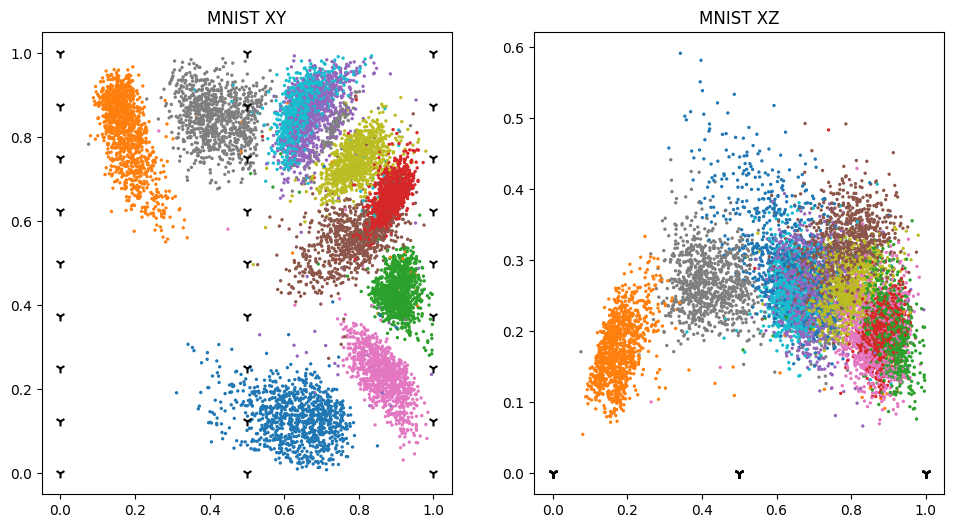

[16324] Reconstruction loss: -2.0392, KLD: 0.0000 AUC 0.7978 FZ 0.9549 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0318 SHANNON 0.14451026916503906
[16536] Reconstruction loss: -2.0307, KLD: 0.0000 AUC 0.8198 FZ 0.9682 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0319 SHANNON 0.14658832550048828
[16748] Reconstruction loss: -2.0546, KLD: 0.0000 AUC 0.8462 FZ 0.8527 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0320 SHANNON 0.14234662055969238
[16960] Reconstruction loss: -2.0149, KLD: 0.0000 AUC 0.8079 FZ 0.9704 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0322 SHANNON 0.15010404586791992
[17172] Reconstruction loss: -2.0474, KLD: 0.0000 AUC 0.8356 FZ 0.8337 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0324 SHANNON 0.14298725128173828


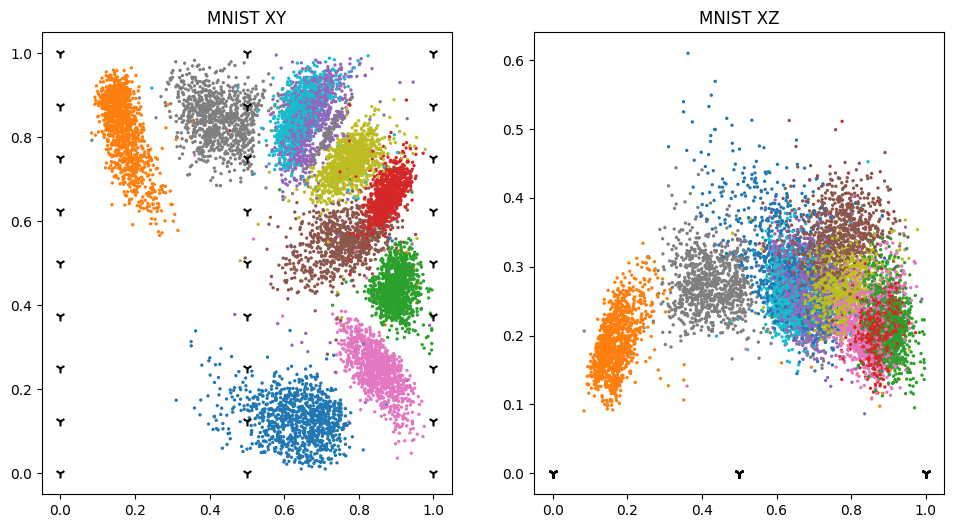

[17384] Reconstruction loss: -2.0512, KLD: 0.0000 AUC 0.8271 FZ 0.8203 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0325 SHANNON 0.1437835693359375
[17596] Reconstruction loss: -2.0610, KLD: 0.0000 AUC 0.8252 FZ 0.8849 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0327 SHANNON 0.1467428207397461
[17808] Reconstruction loss: -1.9854, KLD: 0.0000 AUC 0.7556 FZ 0.7203 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0329 SHANNON 0.14017391204833984
[18020] Reconstruction loss: -2.0394, KLD: 0.0000 AUC 0.8397 FZ 0.8142 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0332 SHANNON 0.14689159393310547
[18232] Reconstruction loss: -2.0619, KLD: 0.0000 AUC 0.8391 FZ 0.7984 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0334 SHANNON 0.1452491283416748


[18444] Reconstruction loss: -2.0302, KLD: 0.0000 AUC 0.8241 FZ 0.7148 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0335 SHANNON 0.14132404327392578
[18656] Reconstruction loss: -2.0054, KLD: 0.0000 AUC 0.8094 FZ 0.6846 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0337 SHANNON 0.14122390747070312
[18868] Reconstruction loss: -2.0293, KLD: 0.0000 AUC 0.8282 FZ 0.8125 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0339 SHANNON 0.14861798286437988
[19080] Reconstruction loss: -2.0488, KLD: 0.0000 AUC 0.8462 FZ 0.7712 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0339 SHANNON 0.14607715606689453
[19292] Reconstruction loss: -2.0601, KLD: 0.0000 AUC 0.8375 FZ 0.7759 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0340 SHANNON 0.14523911476135254


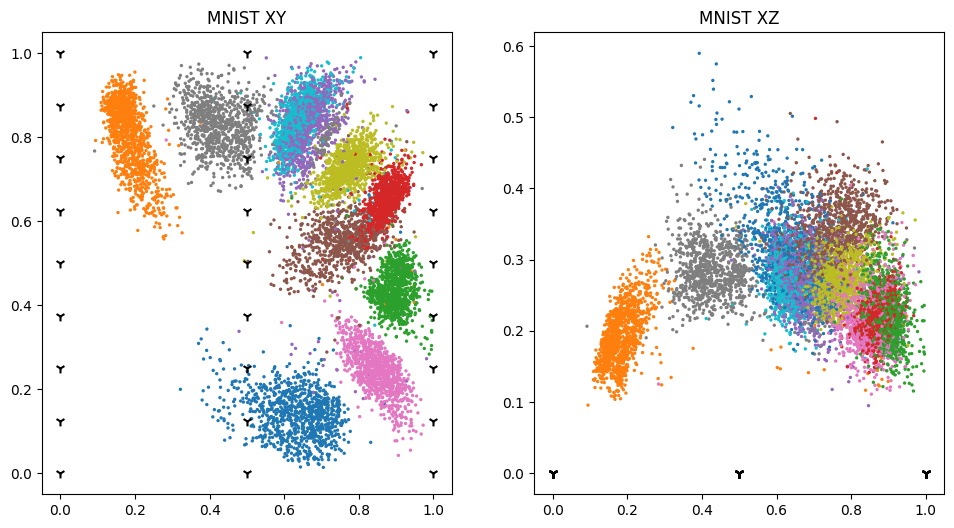

[19504] Reconstruction loss: -2.0475, KLD: 0.0000 AUC 0.8272 FZ 0.7738 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0341 SHANNON 0.1450824737548828
[19716] Reconstruction loss: -2.0581, KLD: 0.0000 AUC 0.8390 FZ 0.7552 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0342 SHANNON 0.1481623649597168
[19928] Reconstruction loss: -2.0461, KLD: 0.0000 AUC 0.8490 FZ 0.7942 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0343 SHANNON 0.14878034591674805
[20140] Reconstruction loss: -2.0364, KLD: 0.0000 AUC 0.8298 FZ 0.7485 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0343 SHANNON 0.14414429664611816
[20352] Reconstruction loss: -2.0495, KLD: 0.0000 AUC 0.8297 FZ 0.7717 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0344 SHANNON 0.1490163803100586


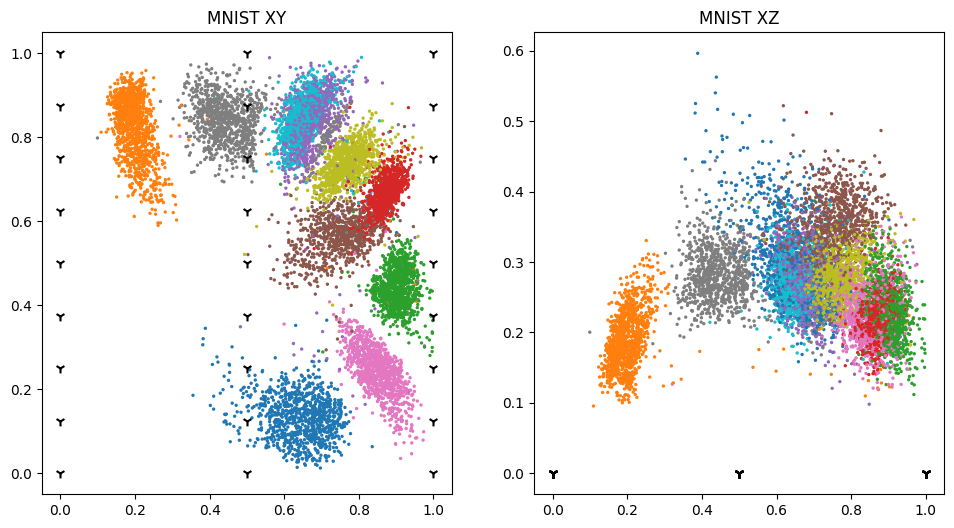

[20564] Reconstruction loss: -2.0651, KLD: 0.0000 AUC 0.8412 FZ 0.7377 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0345 SHANNON 0.14781570434570312
[20776] Reconstruction loss: -2.0490, KLD: 0.0000 AUC 0.8346 FZ 0.6894 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0346 SHANNON 0.1436307430267334
[20988] Reconstruction loss: -2.0268, KLD: 0.0000 AUC 0.8400 FZ 0.8525 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0345 SHANNON 0.15244436264038086
[21200] Reconstruction loss: -2.0276, KLD: 0.0000 AUC 0.7896 FZ 0.7850 FZVOL 24.0100 CENTROIDS DISCREPANCY 0.0345 SHANNON 0.1469881534576416


In [152]:
for epoch in range(num_epochs):
    prev_updates = train(model, train_loader, optimizer, sched, prev_updates, epoch, writer=writer)
    test(model, test_loader, prev_updates, epoch, writer=writer)
    #scheduler.step()
    


In [153]:
(model.decoder.fuzzy[2].get_norm_stats() - 1.0/fuzzy_rules_count).abs().sum()

tensor(0.4549, device='cuda:0')

In [154]:
keep_eigenvals_positive_loss(model.decoder.fuzzy[1])

tensor(-1.0000e-15, device='cuda:0')

## Визуализируем результаты

In [155]:

def get_activation_stats(model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, _) in enumerate(tqdm(dataloader)):
            data = data.to(device)
            _, _, fz = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind in act_fz:
                rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat

train_stat = get_activation_stats(model, train_loader)
test_stat = get_activation_stats(model, test_loader)

plt.bar(list(train_stat.keys()), train_stat.values(), 0.5, color='g')
plt.bar(list(test_stat.keys()), test_stat.values(), 0.5, color='r')

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

<BarContainer object of 22 artists>

In [156]:
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import accuracy_score

# train_x = []
# test_x = []
# test_y = []
# with torch.no_grad():
#     for _, (data, _) in enumerate(tqdm(train_loader)):
#         data = data.to(device)
#         fz, _, _ = model.forward(data)
#         for f in fz:
#             train_x.append(f.cpu().numpy())

# with torch.no_grad():
#     for _, (data, target) in enumerate(tqdm(test_loader)):
#         data = data.to(device)
#         fz, _, _  = model.forward(data)
#         for f, trg in zip(fz, target):
#             test_x.append(f.cpu().numpy())
#             if trg == mnist_class_anomaly:
#                 test_y.append(-1)
#             else:
#                 test_y.append(1)
    
# clf = IsolationForest(random_state=0, n_estimators=1000).fit(train_x)
# y_pred =clf.predict(test_x)
# disp = ConfusionMatrixDisplay(confusion_matrix(test_y, y_pred))
# disp.plot()
# accuracy_score(test_y, y_pred)

  0%|          | 0/40 [00:00<?, ?it/s]

(-1.0, 28.0)

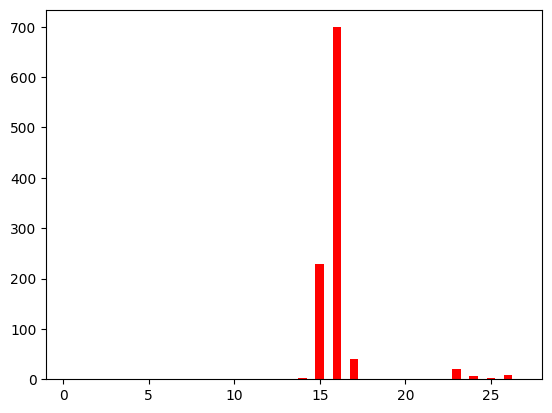

In [157]:

def get_activation_stats_by_digit(digit, model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, target) in enumerate(tqdm(dataloader)):
        
            data = data.to(device)
            _, _, fz = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind, trg in zip(act_fz, target):
                if trg == digit:
                    rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat


test_stat_by_digit = get_activation_stats_by_digit(9, model, test_loader)

plt.bar(list(test_stat_by_digit.keys()), test_stat_by_digit.values(), 0.5, color='r')
plt.xlim((-1, fuzzy_rules_count + 1))

In [158]:
test_stat_by_digit

{17: 40, 15: 229, 16: 699, 26: 8, 24: 6, 25: 3, 23: 20, 20: 1, 14: 3}

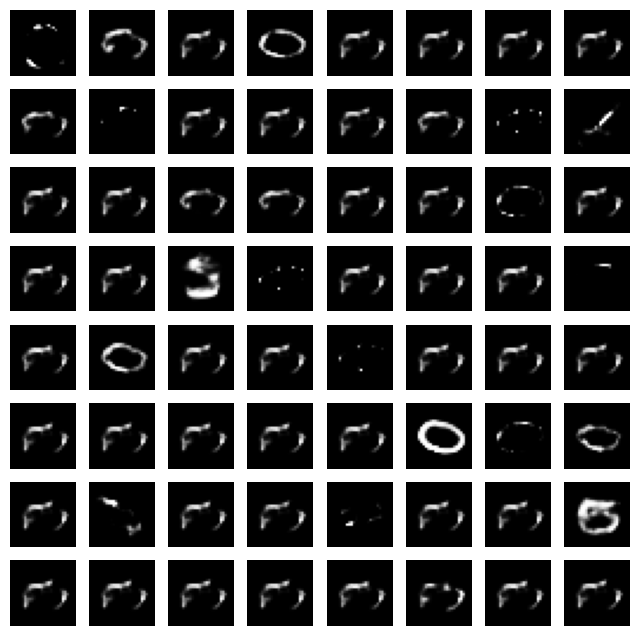

In [159]:
z = torch.randn(64, latent_dim).to(device)
samples, _ = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')


In [160]:
# fz = torch.zeros(64, fuzzy_rules_count).to(device)
# for i in range(64):
#     fz[i][5] = 1.0/(i+1)

# samples = model.decoder.decode_from_fz(fz)

# # Plot the generated images
# fig, ax = plt.subplots(8, 8, figsize=(8, 8))
# for i in range(8):
#     for j in range(8):
#         ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
#         ax[i, j].axis('off')

# # plt.show()
# plt.savefig('cvae_mnist.webp')

In [161]:
ssim = piqa.SSIM(window_size = 9, n_channels=1, reduction='none').to(device)
def get_arate(inp):
    _, x_recon, fz_1 = model.forward(inp)
    #_, x_recon, fz_2 = model.forward(x_recon)
    
    return (1 - ssim(x_recon.clamp(0, 1), inp)).cpu().numpy() #(1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# (1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy() #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

MNIST HIST:   0%|          | 0/40 [00:00<?, ?it/s]

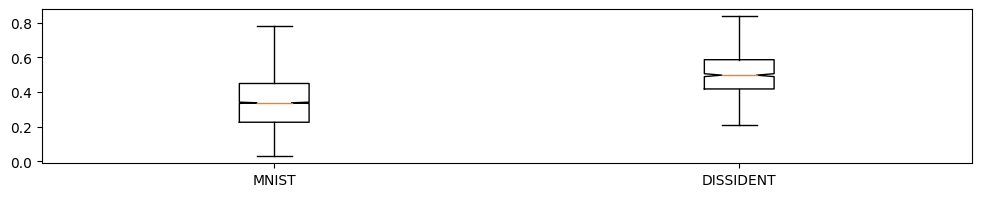

In [162]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_class_anomaly:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

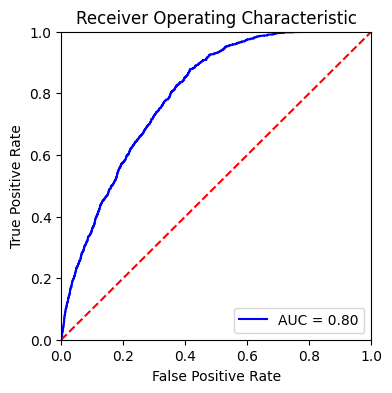

In [163]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

In [164]:
def show_plot():
    centroids = model.decoder.fuzzy[1].get_centroids().detach().cpu().numpy()
    embedings = []
    labels_expected = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Encoding'):
            data = data.view((-1,1,28,28)).to(device)
            embeding,_,_ = model.forward(data)
            embedings.append(embeding.cpu().numpy())
            labels_expected.append(target.cpu().numpy())
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    plt.figure(figsize=(18, 6))

    R, C = 1, 3

    plt.subplot(R, C, 1)
    plt.title("MNIST XY")
    plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)

    plt.subplot(R, C, 2)
    plt.title("MNIST XZ")
    plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)

    
show_plot()

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [165]:
def show_item_reconstructio(ind):
    for data, trg in iter(test_loader):
        data = data.to(device)
        _, x_rec, fz = model.forward(data)
        #_, x_rec_2, fz_2 = model.forward(x_rec)

        plt.figure(figsize=(24, 6))

        R, C = 1, 6

        #plt.subplot(R, C, 1)
        #plt.imshow(fz[ind].detach().cpu().squeeze())
        #plt.bar(range(fuzzy_rules_count), fz[ind].detach().cpu().numpy(), color='g')
        #plt.bar(range(fuzzy_rules_count), fz_2[ind].detach().cpu().numpy(), color='r')
        plt.subplot(R, C, 1)
        plt.imshow(data[ind].cpu().squeeze())
        plt.subplot(R, C, 2)
        plt.imshow(x_rec[ind].detach().cpu().squeeze())
        #plt.subplot(R, C, 3)
        #plt.imshow(x_rec_2[ind].detach().cpu().squeeze())
        plt.subplot(R, C, 3)
        plt.imshow((x_rec[ind] - data[ind]).abs().detach().cpu().squeeze())
        #plt.subplot(R, C, 4)
        #plt.imshow(((data[ind]-x_rec[ind]).abs() - x_resd[ind]).abs().clamp(min=0.2).abs().detach().cpu().squeeze())
        break

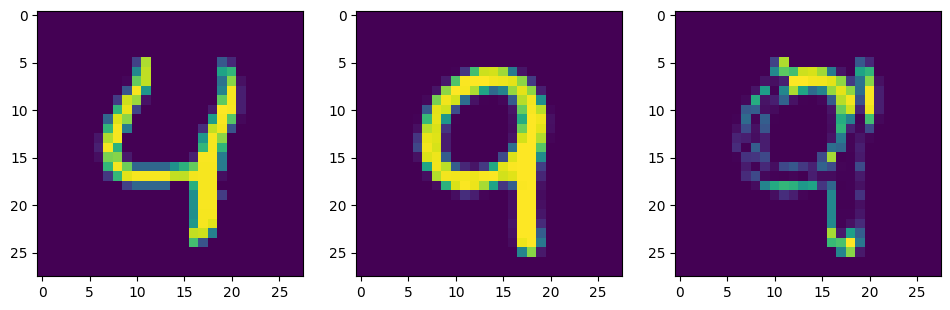

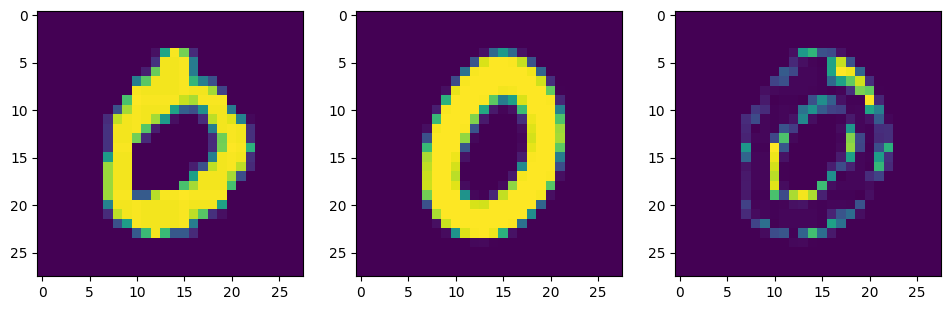

In [166]:
show_item_reconstructio(4)
show_item_reconstructio(3)